In [ ]:
import pandas as pd
import numpy as np
import random
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score
import seaborn as sns
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
import joblib

In [ ]:
def generate_synthetic_data(n=5000):
    np.random.seed(42)
    random.seed(42)
    customer_ids = [f"CUST{i}" for i in range(1, n + 1)]
    age = np.random.randint(18, 80, n)
    gender = np.random.choice(['Male', 'Female'], n)
    contract_type = np.random.choice(['Month-to-month', 'One year', 'Two year'], n, p=[0.5, 0.3, 0.2])
    monthly_charges = np.round(np.random.uniform(20, 120, n), 2)
    tenure = np.random.randint(1, 72, n)
    total_charges = np.round(monthly_charges * tenure + np.random.uniform(-10, 10, n), 2)
    tech_support = np.random.choice(['Yes', 'No'], n, p=[0.3, 0.7])
    internet_service = np.random.choice(['DSL', 'Fiber optic', 'No'], n, p=[0.4, 0.4, 0.2])
    paperless_billing = np.random.choice(['Yes', 'No'], n, p=[0.7, 0.3])
    payment_method = np.random.choice(['Electronic check', 'Mailed check', 'Bank transfer', 'Credit card'], n)
    churn = np.random.choice(['Yes', 'No'], n, p=[0.2, 0.8])
    df = pd.DataFrame({
        'CustomerID': customer_ids,
        'Age': age,
        'Gender': gender,
        'ContractType': contract_type,
        'MonthlyCharges': monthly_charges,
        'TotalCharges': total_charges,
        'TechSupport': tech_support,
        'InternetService': internet_service,
        'Tenure': tenure,
        'PaperlessBilling': paperless_billing,
        'PaymentMethod': payment_method,
        'Churn': churn
    })
    df['AverageMonthlyCharges'] = df['TotalCharges'] / df['Tenure']
    df['CustomerLifetimeValue'] = df['Tenure'] * df['MonthlyCharges']
    return df
data = generate_synthetic_data()
print(data.head())

  CustomerID  Age  Gender    ContractType  MonthlyCharges  TotalCharges  \
0      CUST1   56    Male        Two year           85.58       1541.69   
1      CUST2   69  Female  Month-to-month           69.70       4731.09   
2      CUST3   46  Female  Month-to-month           23.21       1111.04   
3      CUST4   32  Female        One year           81.23       5680.62   
4      CUST5   60  Female        One year           91.62       6142.92   

  TechSupport InternetService  Tenure PaperlessBilling     PaymentMethod  \
0          No              No      18              Yes       Credit card   
1          No     Fiber optic      68              Yes  Electronic check   
2         Yes             DSL      48              Yes      Mailed check   
3         Yes     Fiber optic      70              Yes       Credit card   
4          No              No      67               No     Bank transfer   

  Churn  AverageMonthlyCharges  CustomerLifetimeValue  
0    No              85.649444      

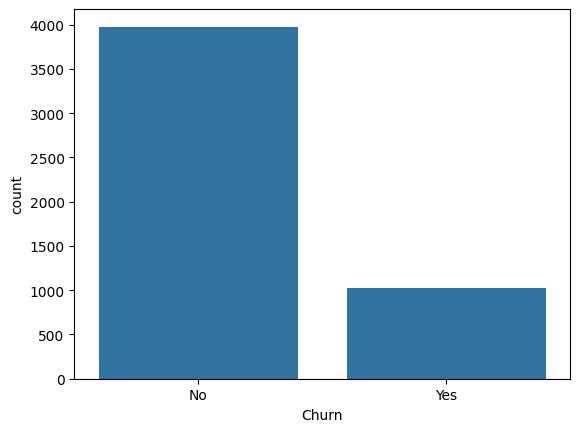

In [ ]:
sns.countplot(x='Churn', data=data)
plt.show()

In [ ]:
data.fillna(data.select_dtypes(include=[np.number]).mean(), inplace=True)
label_encoders = {}
for col in ['Gender', 'ContractType', 'TechSupport', 'InternetService', 'PaperlessBilling', 'PaymentMethod', 'Churn']:
    le = LabelEncoder()
    data[col] = le.fit_transform(data[col])
    label_encoders[col] = le
X = data.drop(columns=['CustomerID', 'Churn'])
y = data['Churn']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
smote = SMOTE(random_state=42)
X_train, y_train = smote.fit_resample(X_train, y_train)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [ ]:
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

In [ ]:
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("ROC AUC Score:", roc_auc_score(y_test, rf.predict_proba(X_test)[:, 1]))

Accuracy: 0.675
Classification Report:
               precision    recall  f1-score   support

           0       0.81      0.78      0.79       807
           1       0.21      0.24      0.22       193

    accuracy                           0.68      1000
   macro avg       0.51      0.51      0.51      1000
weighted avg       0.69      0.68      0.68      1000

Confusion Matrix:
 [[629 178]
 [147  46]]
ROC AUC Score: 0.5109309089508253


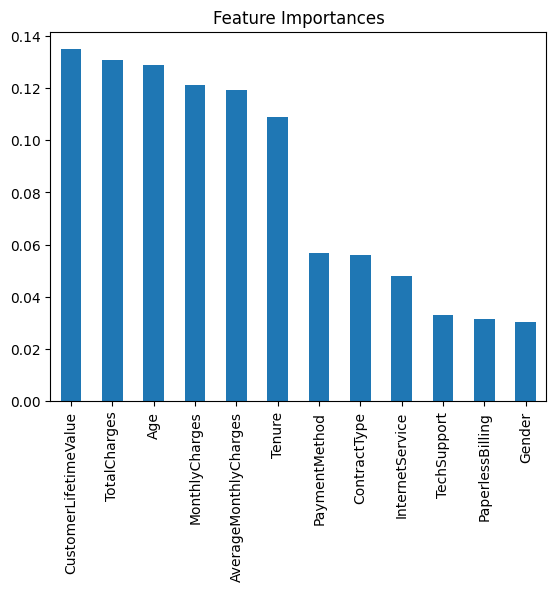

In [ ]:
importances = pd.Series(rf.feature_importances_, index=X.columns).sort_values(ascending=False)
importances.plot(kind='bar', title='Feature Importances')
plt.show()

In [ ]:
joblib.dump(rf, 'churn_model.pkl')
joblib.dump(scaler, 'scaler.pkl')
joblib.dump(label_encoders, 'label_encoders.pkl')

['label_encoders.pkl']

In [ ]:
import joblib
model = joblib.load('churn_model.pkl')
scaler = joblib.load('scaler.pkl')
label_encoders = joblib.load('label_encoders.pkl')

In [ ]:
new_customer = pd.DataFrame({
    'Age': [30],
    'Gender': ['Male'],
    'ContractType': ['Month-to-month'],
    'MonthlyCharges': [70.5],
    'TotalCharges': [850],
    'TechSupport': ['No'],
    'InternetService': ['Fiber optic'],
    'Tenure': [12],
    'PaperlessBilling': ['Yes'],
    'PaymentMethod': ['Electronic check'],
    'AverageMonthlyCharges': [70.5],
    'CustomerLifetimeValue': [70.5 * 12]
})
categorical_columns = ['Gender', 'ContractType', 'TechSupport', 'InternetService', 'PaperlessBilling', 'PaymentMethod']
for col in categorical_columns:
    new_customer[col] = new_customer[col].astype(str)
    existing_classes = label_encoders[col].classes_
    new_customer[col] = new_customer[col].apply(lambda x: x if x in existing_classes else existing_classes[0])
    new_customer[col] = label_encoders[col].transform(new_customer[col])
new_customer_scaled = scaler.transform(new_customer)
churn_prediction = model.predict(new_customer_scaled)
churn_probability = model.predict_proba(new_customer_scaled)[:, 1]
print(f"Churn Prediction: {'Yes' if churn_prediction[0] == 1 else 'No'}")
print(f"Churn Probability: {churn_probability[0]:.2f}")

Churn Prediction: Yes
Churn Probability: 0.83
